In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import PIL
import imageio
import skimage

from IPython import display
# %matplotlib inline
%matplotlib notebook

tfk = tf.keras
tfkl = tf.keras.layers

/opt/conda/envs/vice/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from softlearning.models.state_estimation import get_dumped_pkl_data
images_path = '/root/nfs/kun1/users/justinvyu/data/fixed_data_with_states.pkl'
images, states = get_dumped_pkl_data(images_path)

Choosing the latest nvidia driver: /usr/lib/nvidia-384, among ['/usr/lib/nvidia-000', '/usr/lib/nvidia-384']
Choosing the latest nvidia driver: /usr/lib/nvidia-384, among ['/usr/lib/nvidia-000', '/usr/lib/nvidia-384']


In [3]:
from softlearning.preprocessors.utils import get_vae_preprocessor

encoder_weights_fn = '/root/softlearning/softlearning/models/vae_3_dim_beta_1_invisible_claw/encoder_3_dim_1.0_beta.h5'
decoder_weights_fn = '/root/softlearning/softlearning/models/vae_3_dim_beta_1_invisible_claw/decoder_3_dim_1.0_beta.h5'

vae_preprocessor_params = {
    'type': 'VAEPreprocessor',
    'kwargs': {
        'encoder_path': encoder_weights_fn,
        'decoder_path': decoder_weights_fn,
        'trainable': False,
        'image_shape': (32, 32, 3),
        'latent_dim': 3,
        'include_decoder': False,
    }
}
vae_encoder = get_vae_preprocessor(**vae_preprocessor_params['kwargs'])

> /root/softlearning/softlearning/models/vae.py(251)get_encoder()
    250         import ipdb; ipdb.set_trace()
--> 251         encoder = self.create_encoder_model(
    252             self.image_shape, trainable=trainable, name=name)

ipdb> c
Model: "vae_preprocessor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
____

In [28]:
rand_indices = np.random.choice(images.shape[0], size=1000)
images_to_visualize = images[rand_indices]
states_to_visualize = states[rand_indices]
latents = vae_encoder.predict(images_to_visualize)

In [ ]:
for img, latent in zip(images_to_visualize, latents):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(latent[0], latent[1], latent[2])
    plt.show()
    plt.imshow(img)
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=Axes3D.name)

xs, ys, zs = latents[:, 0], latents[:, 1], latents[:, 2]

ax.scatter(xs, ys, zs, marker="o")

# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111,frame_on=False) 
ax2.axis("off")
ax2.axis([0,1,0,1])

def proj(X, ax1, ax2):
    """ From a 3D point in axes ax1, 
        calculate position in 2D in ax2 """
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))

def image(ax, arr, xy):
    """ Place an image (arr) as annotation at position xy """
    im = offsetbox.OffsetImage(arr, zoom=0.5)
    im.image.axes = ax
    ab = offsetbox.AnnotationBbox(im, xy, xybox=(0, 0),
                        xycoords='data', boxcoords="offset points",
                        pad=0, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)


for i, s in enumerate(zip(xs, ys, zs)):
    x, y = proj(s, ax, ax2)
    image(ax2, images_to_visualize[i], [x, y])

ax.set_xlabel('z_0')
ax.set_ylabel('z_1')
ax.set_zlabel('z_2')
plt.show()


<IPython.core.display.Javascript object>


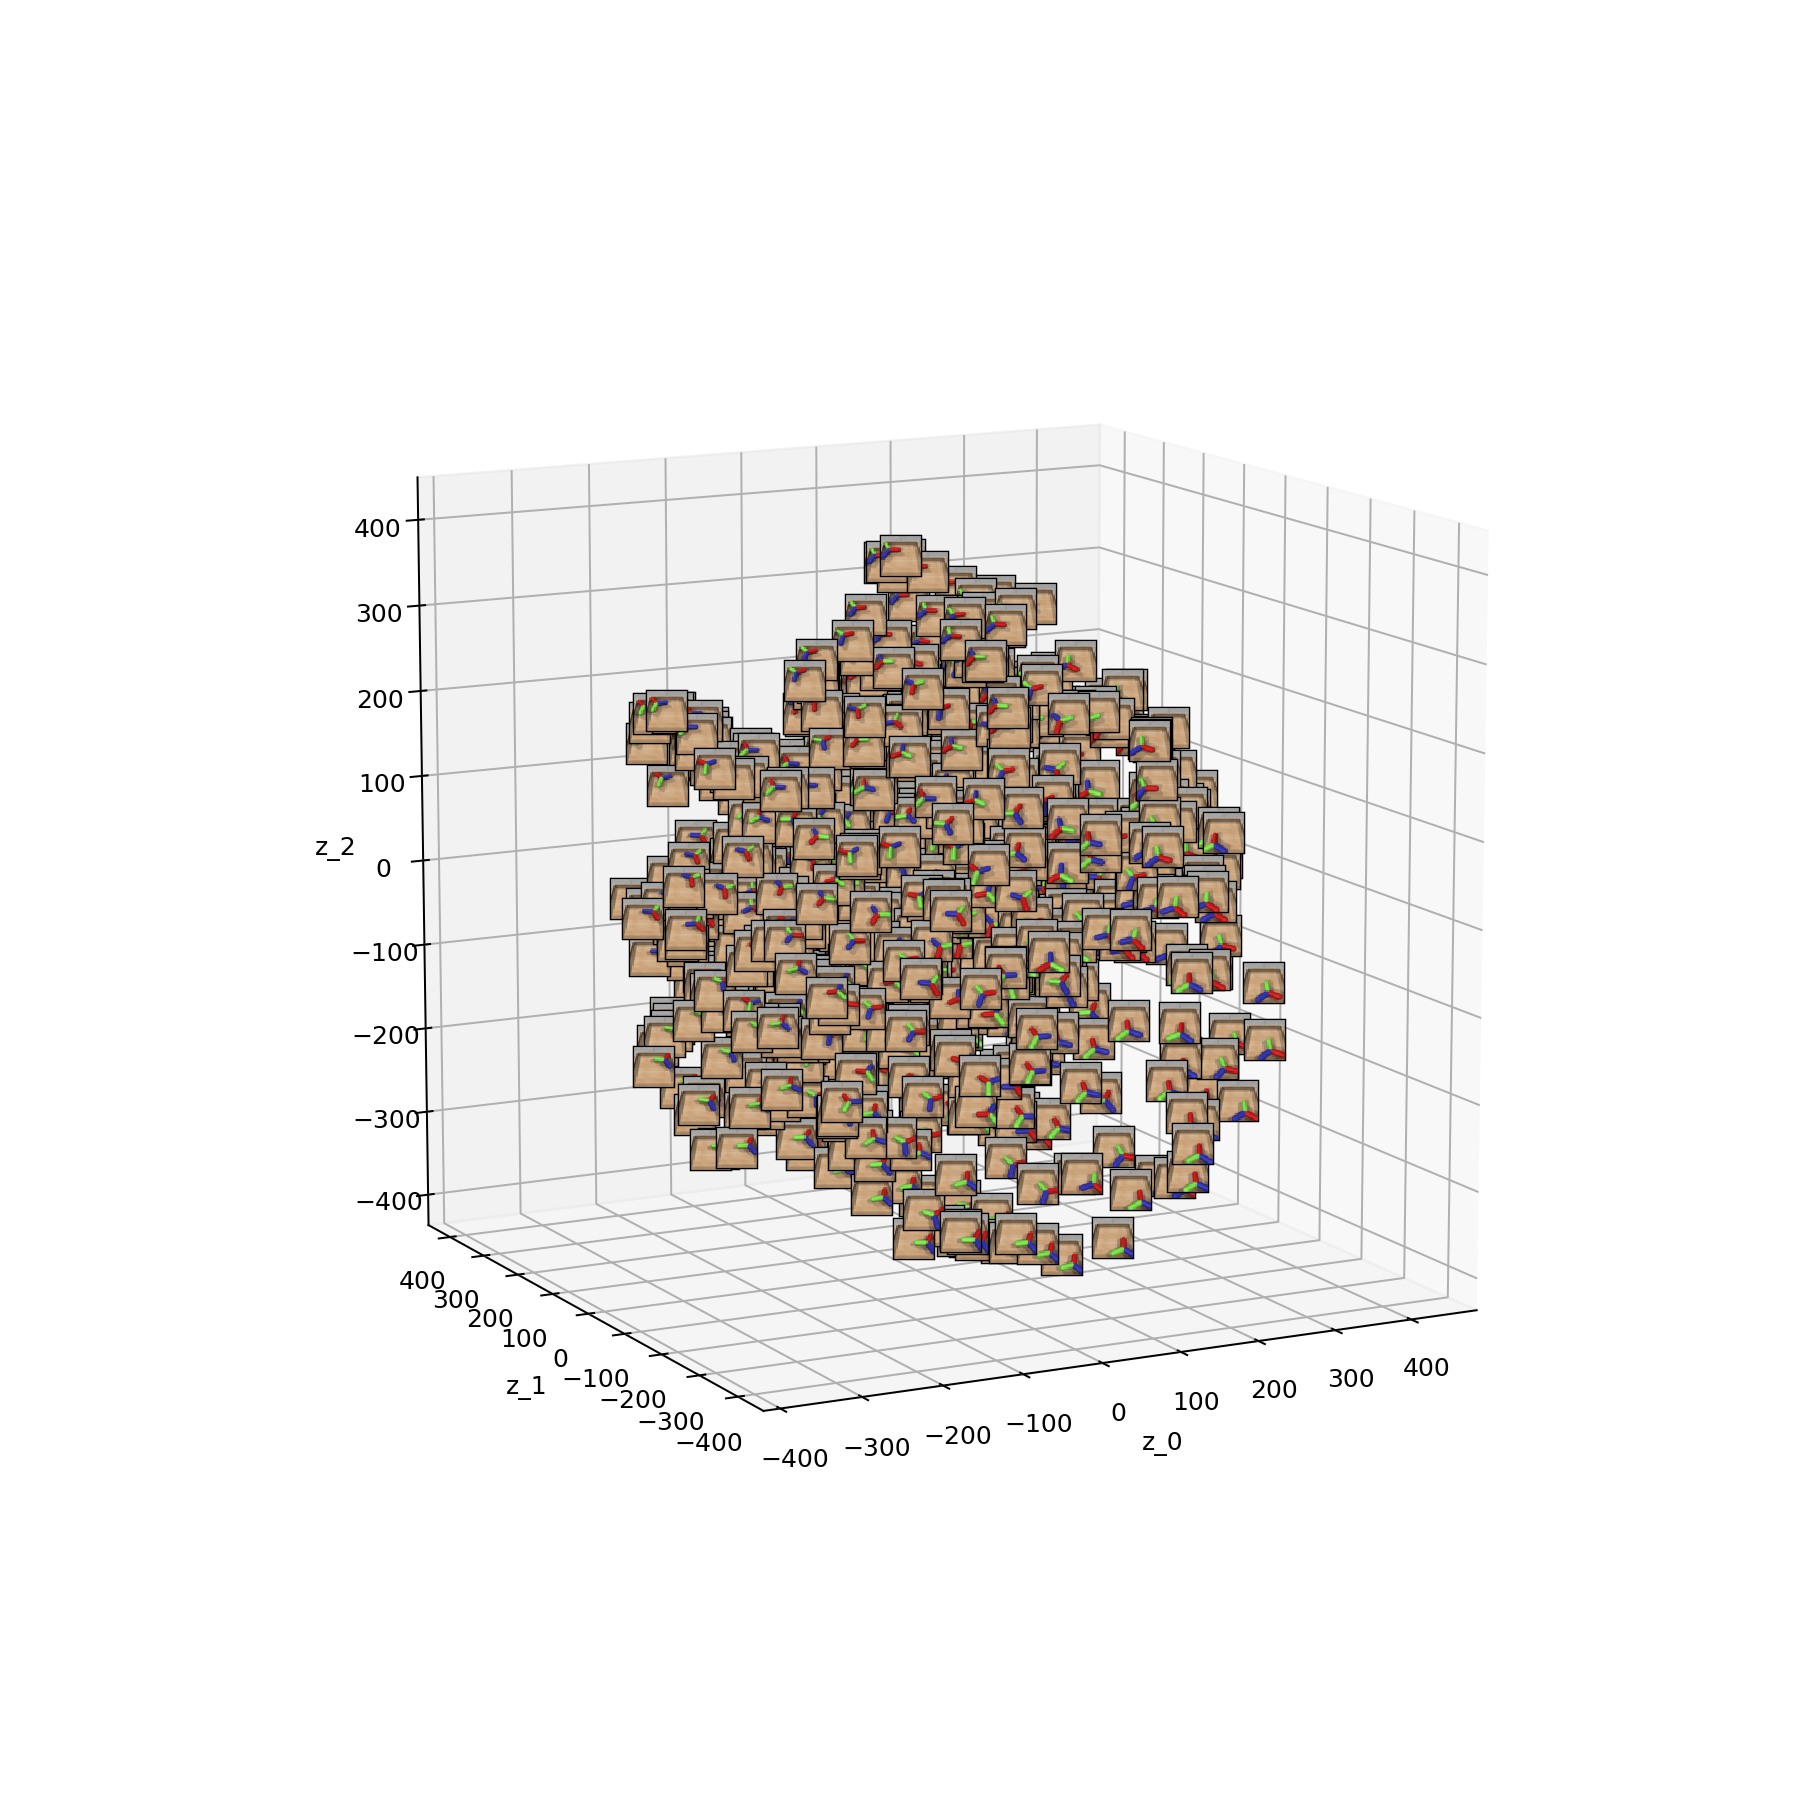

In [45]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import offsetbox

%matplotlib notebook

xs, ys, zs = latents[:, 0], latents[:, 1], latents[:, 2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)

ax.scatter(xs, ys, zs, marker="o")

# Create a dummy axes to place annotations to
ax2 = fig.add_subplot(111, frame_on=False) 
ax2.axis("off")
ax2.axis([0,1,0,1])

class ImageAnnotations3D():
    def __init__(self, xyz, imgs, ax3d,ax2d):
        self.xyz = xyz
        self.imgs = imgs
        self.ax3d = ax3d
        self.ax2d = ax2d
        self.annot = []
        for s,im in zip(self.xyz, self.imgs):
            x,y = self.proj(s)
            self.annot.append(self.image(im,[x,y]))
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect("draw_event",self.update)

        self.funcmap = {"button_press_event" : self.ax3d._button_press,
                        "motion_notify_event" : self.ax3d._on_move,
                        "button_release_event" : self.ax3d._button_release}

        self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb) \
                        for kind in self.funcmap.keys()]

    def cb(self, event):
        event.inaxes = self.ax3d
        self.funcmap[event.name](event)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x,y,z = X
        x2, y2, _ = proj3d.proj_transform(x,y,z, self.ax3d.get_proj())
        tr = self.ax3d.transData.transform((x2, y2))
        return self.ax2d.transData.inverted().transform(tr)

    def image(self,arr,xy):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr, zoom=0.5)
        im.image.axes = ax
        ab = offsetbox.AnnotationBbox(im, xy, xybox=(0, 0),
                            xycoords='data', boxcoords="offset points",
                            pad=0)
        self.ax2d.add_artist(ab)
        return ab

    def update(self,event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                        np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s,ab in zip(self.xyz, self.annot):
                ab.xy = self.proj(s)

ia = ImageAnnotations3D(np.c_[xs,ys,zs], images_to_visualize, ax, ax2)

ax.set_xlabel('z_0')
ax.set_ylabel('z_1')
ax.set_zlabel('z_2')
plt.show()

In [29]:
# Cluster based on state position, then color differently in the latent space
from sklearn.cluster import KMeans
xy_states = states_to_visualize[:, :2]
xy_states.shape
kmeans = KMeans(n_clusters=4, random_state=0).fit(xy_states)

In [37]:
kmeans.cluster_centers_

array([[ 0.52974798,  0.42876055],
       [ 0.51858526, -0.46023998],
       [-0.47135601, -0.5646529 ],
       [-0.46165132,  0.53865498]])

<IPython.core.display.Javascript object>


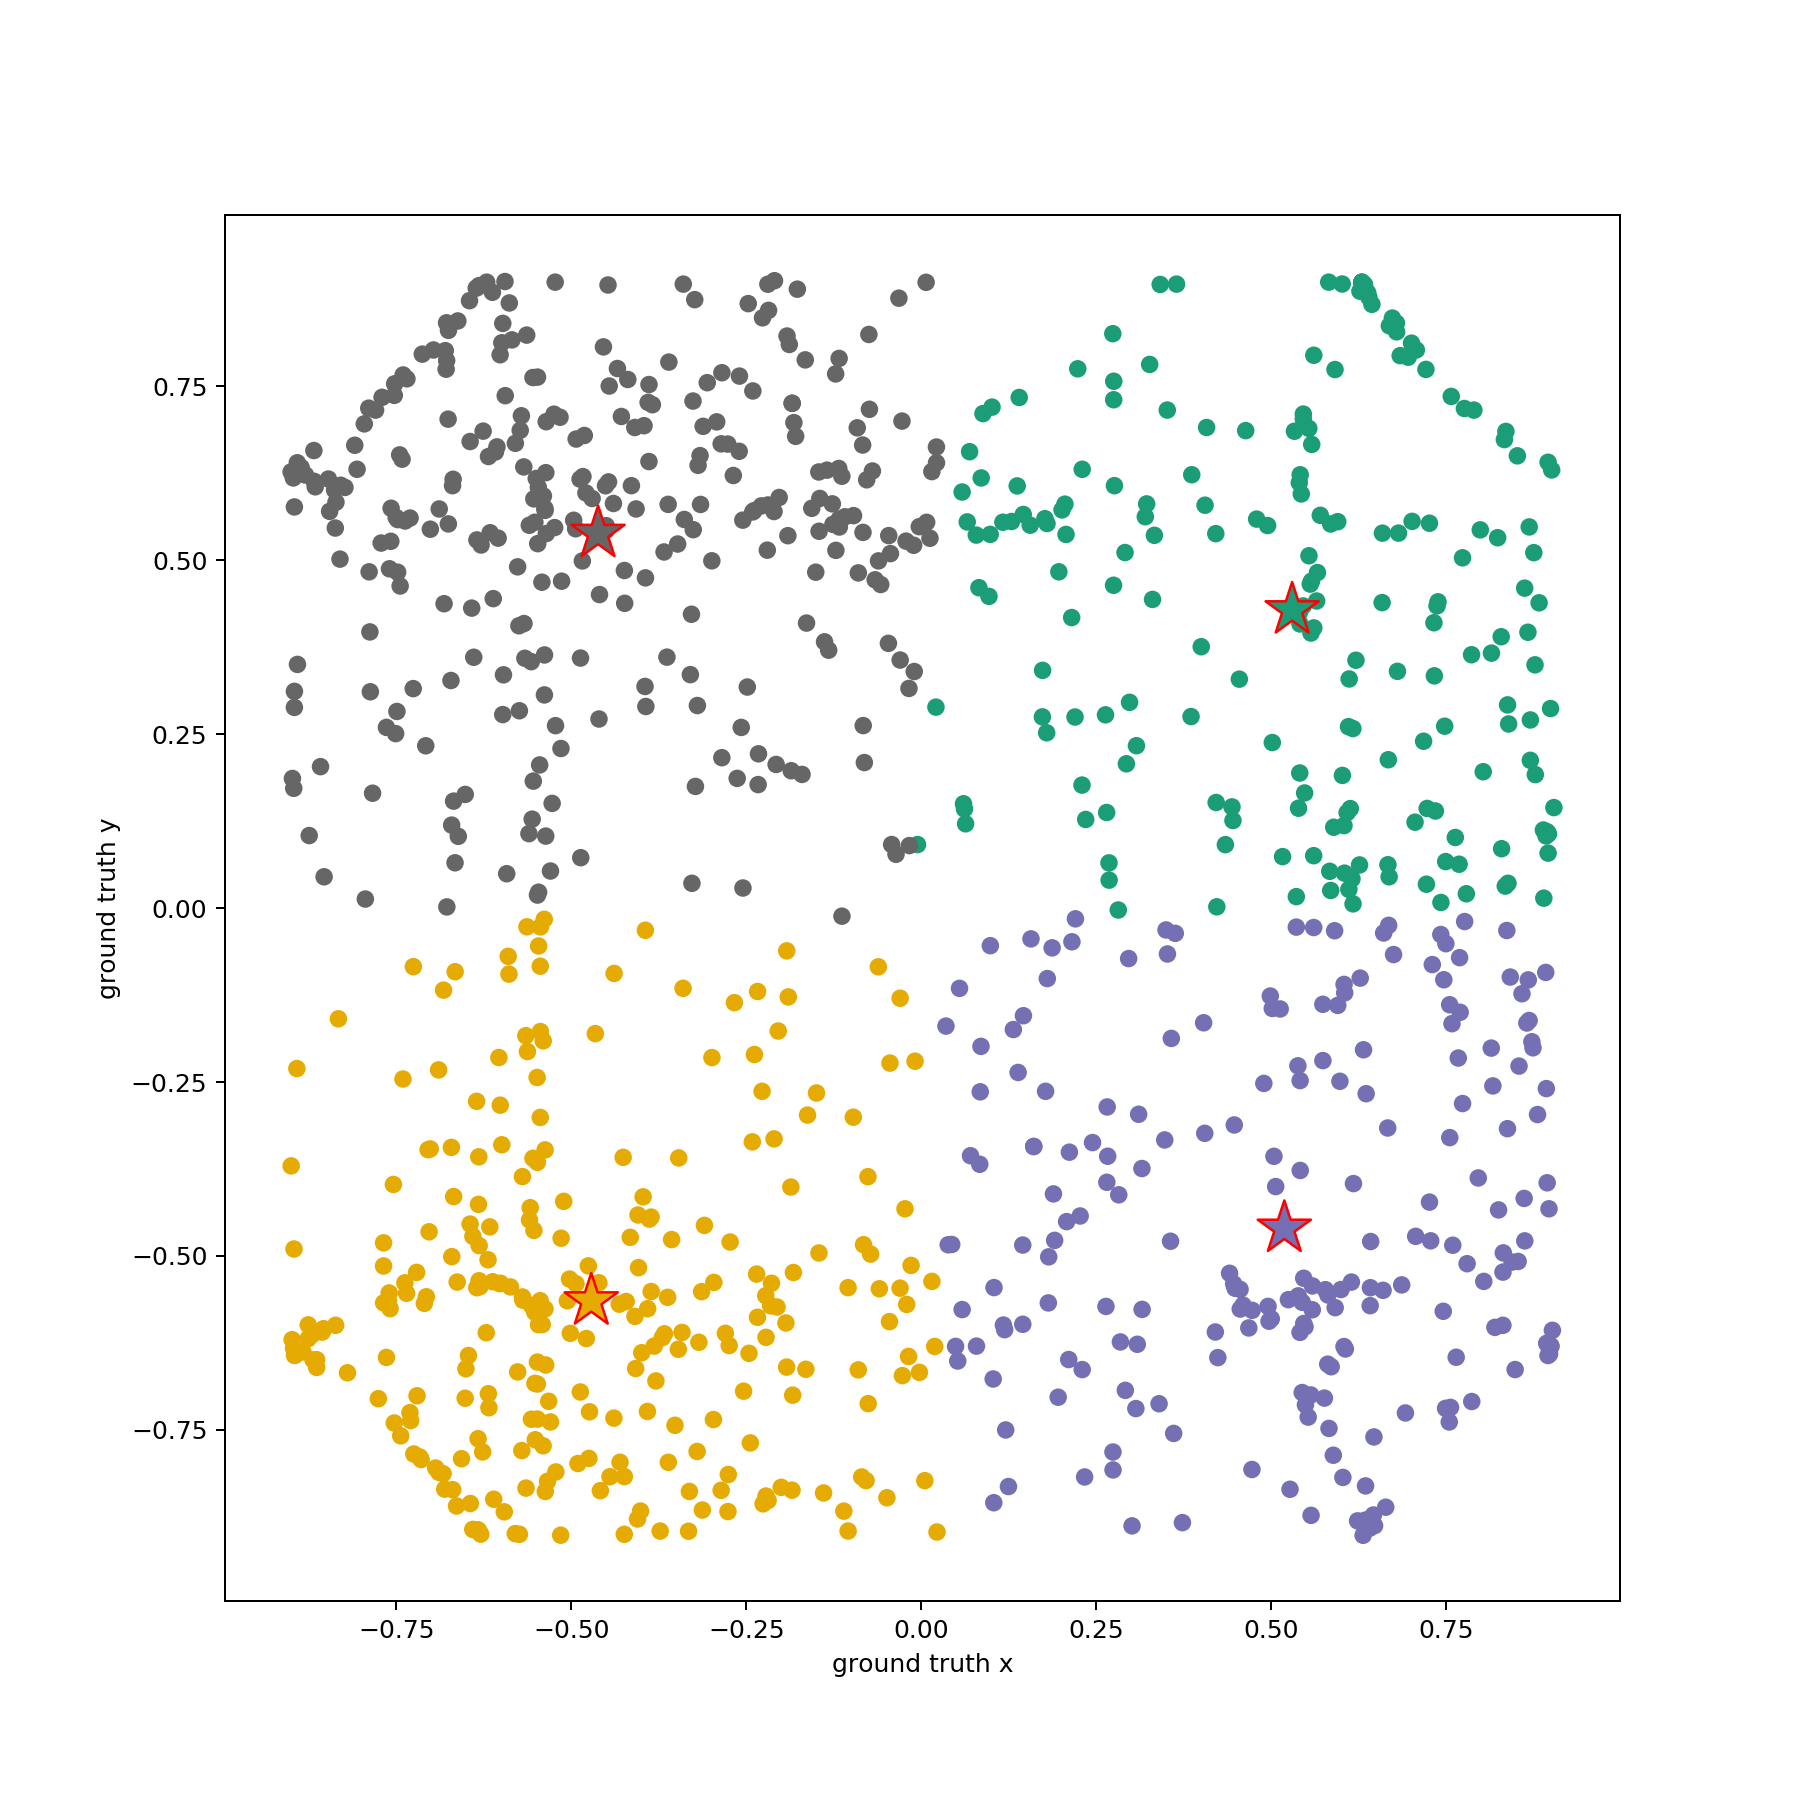

In [44]:
plt.figure(figsize=(10, 10))
plt.xlabel('ground truth x')
plt.ylabel('ground truth y')
plt.scatter(xy_states[:, 0], xy_states[:, 1], c=kmeans.labels_, marker='o', cmap='Dark2')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            c=np.arange(centroids.shape[0]),
            marker='*',
            edgecolors='r',
            s=500,
            cmap='Dark2')
plt.show()

<IPython.core.display.Javascript object>


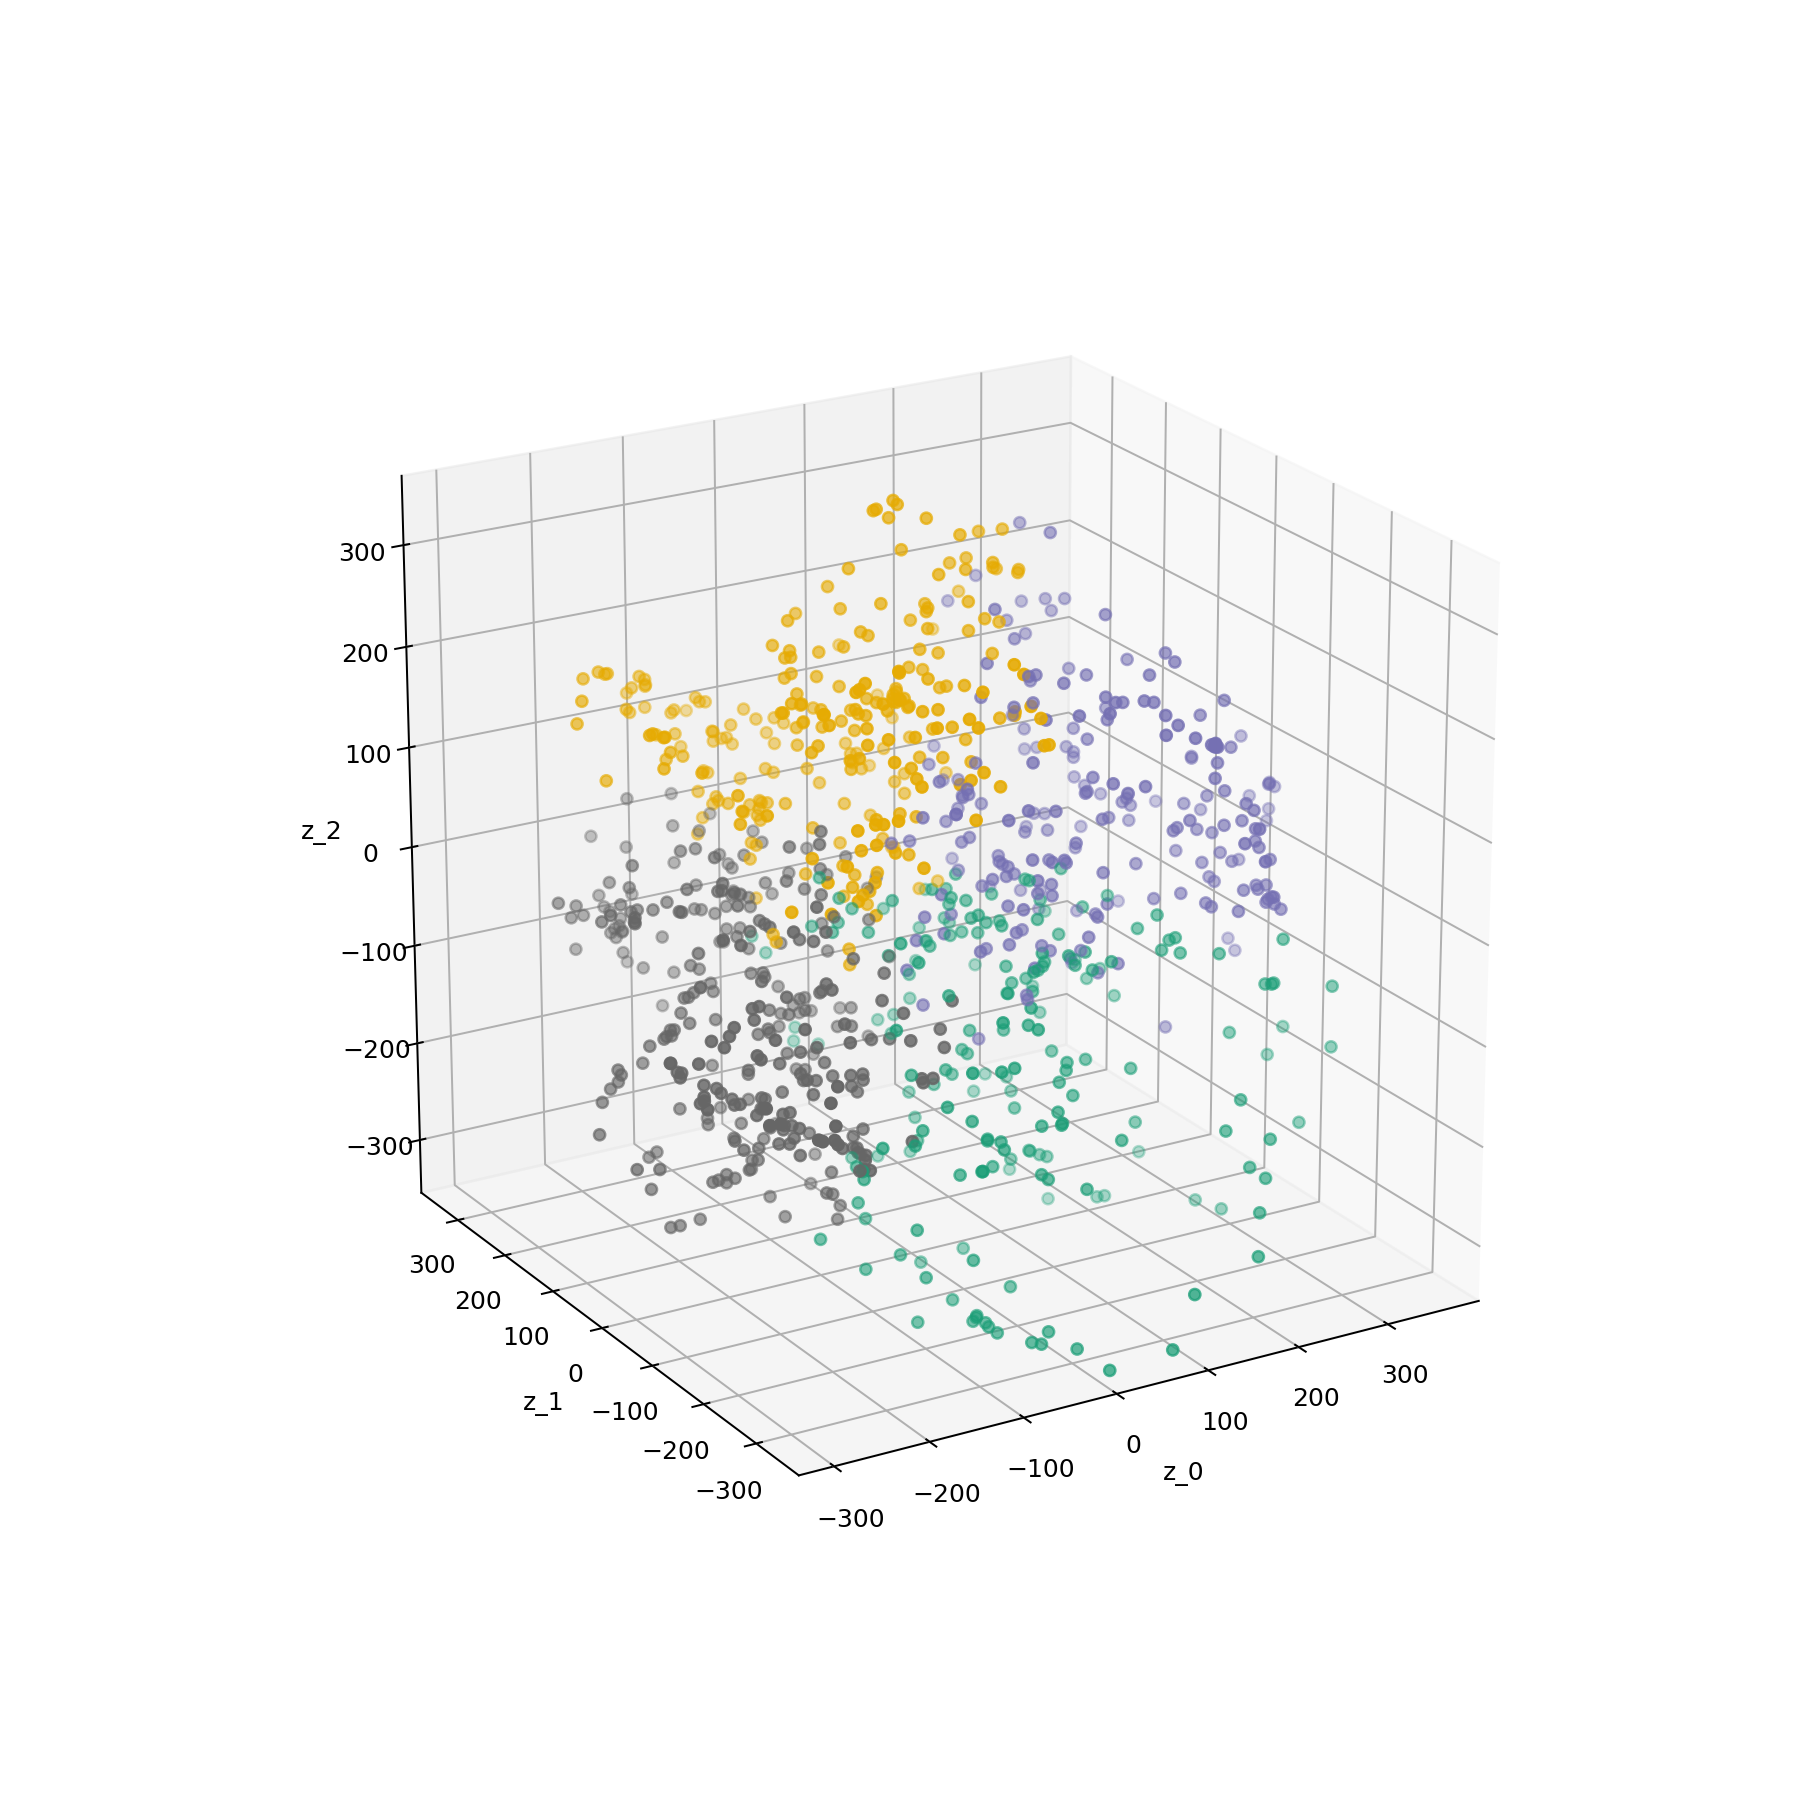

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib import offsetbox

%matplotlib notebook

xs, ys, zs = latents[:, 0], latents[:, 1], latents[:, 2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)

ax.scatter(xs, ys, zs, c=kmeans.labels_, marker="o", cmap='Dark2')

ax.set_xlabel('z_0')
ax.set_ylabel('z_1')
ax.set_zlabel('z_2')
plt.show()